In [1]:
#### Images Analysis

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys
import os


In [2]:
print(f"Dir: {os.getcwd()}")

data_dir = os.getcwd() + "/archive/"
os.chdir(data_dir)


Dir: c:\Users\filoa\Desktop\Programming_trials\Images_analysis


In [3]:
# Getting images

tumor_data = []
healthy_data = []

for f in glob.iglob("./yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor_data.append(img)

for f in glob.iglob("./no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy_data.append(img)

In [5]:

healthy_data = np.array(healthy_data)
tumor_data = np.array(tumor_data)

all_data = np.concatenate((healthy_data, tumor_data))

print(f"Tumor shape: {tumor_data.shape}")
print(f"Healty shape: {healthy_data.shape}")

Tumor shape: (154, 128, 128, 3)
Healty shape: (91, 128, 128, 3)


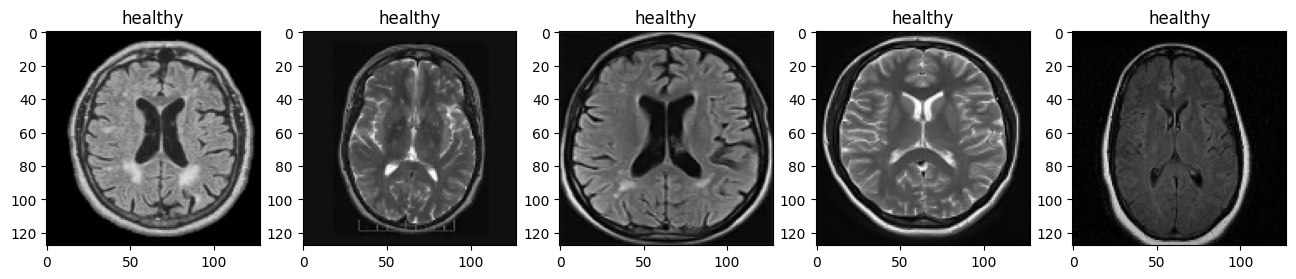

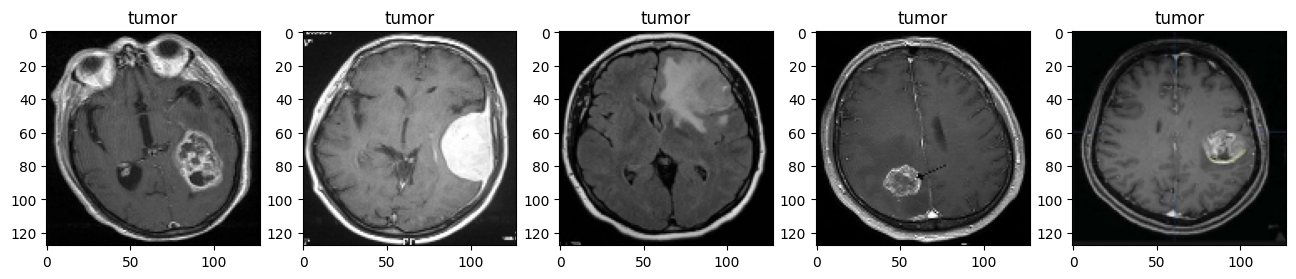

In [6]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])


plot_random(healthy_data, tumor_data, 5)

In [ ]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
    
class MRI(Dataset):

    def __init__(self, tumor_dir, health_dir):

        self.tumor_dir = tumor_dir
        self.healthy_dir = health_dir
        
        tumor = []
        healthy = []
        
        # cv2 - It reads in BGR format by default
        for f in glob.iglob( self.tumor_dir + "*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob(self.healthy_dir + "*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [ ]:
mri_data = MRI(tumor_dir="C:\\Users\\filoa\\Desktop\\Programming_trials\\Images_analysis\\archive\\yes/",
               health_dir="C:\\Users\\filoa\\Desktop\\Programming_trials\\Images_analysis\\archive\\no/")
mri_data.normalize()

In [14]:
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_data, shuffle=True)

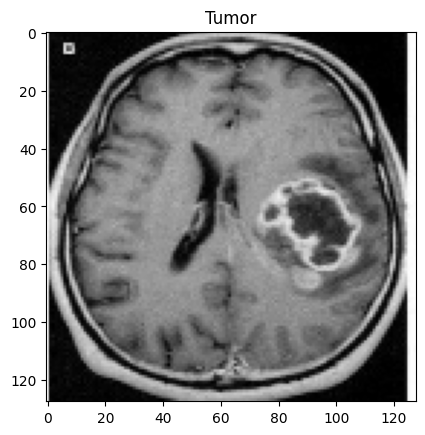

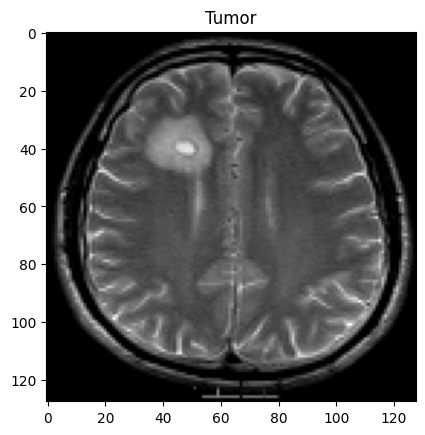

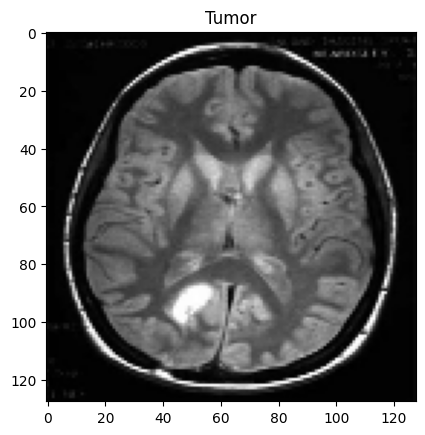

In [11]:

for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 2:
        break

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def __init__(self):

        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5))
            
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)

In [ ]:
model = CNN().to(device)
# dataloader = DataLoader(mri_data, batch_size=32, shuffle=False)
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        

In [23]:
print(outputs)
print(y_true)

[array([[0.5017619]], dtype=float32), array([[0.49926022]], dtype=float32), array([[0.5025762]], dtype=float32), array([[0.5009348]], dtype=float32), array([[0.5013107]], dtype=float32), array([[0.49752784]], dtype=float32), array([[0.49982625]], dtype=float32), array([[0.50145286]], dtype=float32), array([[0.49741867]], dtype=float32), array([[0.49836433]], dtype=float32), array([[0.49744052]], dtype=float32), array([[0.5020229]], dtype=float32), array([[0.50012684]], dtype=float32), array([[0.5006862]], dtype=float32), array([[0.49961233]], dtype=float32), array([[0.49805117]], dtype=float32), array([[0.50118184]], dtype=float32), array([[0.5006738]], dtype=float32), array([[0.50075203]], dtype=float32), array([[0.50119615]], dtype=float32), array([[0.49959835]], dtype=float32), array([[0.49964476]], dtype=float32), array([[0.49993467]], dtype=float32), array([[0.49959192]], dtype=float32), array([[0.5009196]], dtype=float32), array([[0.49850115]], dtype=float32), array([[0.49776578]